In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 39.8 MB/s eta 0:00:00


In [ ]:
save_path = '/content/drive/MyDrive/'
save_path1 = '/content/drive/MyDrive/'

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import vgg16
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!unzip /content/drive/MyDrive/NewData.zip

Archive:  /content/drive/MyDrive/NewData.zip
  inflating: newdata/TestLabels.npy  
  inflating: newdata/ValLabels.npy   
  inflating: newdata/TrainLabels.npy  
  inflating: newdata/ValData.npy     
  inflating: newdata/TestData.npy    
  inflating: newdata/TrainData.npy   


In [ ]:
#Run from here
import os
x_train = []
y_train = []
x_train = np.load("/content/newdata/TrainData.npy")
y_train = np.load("/content/newdata/TrainLabels.npy")

x_val = []
y_val = []
x_val = np.load("/content/newdata/ValData.npy")
y_val = np.load("/content/newdata/ValLabels.npy")

x_test = []
y_test = []
x_test = np.load("/content/newdata/TestData.npy")
y_test = np.load("/content/newdata/TestLabels.npy")

print(f"x_train shape: {x_train .shape} - y_train shape: {y_train .shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test .shape}")

x_train shape: (18123, 110, 110, 3) - y_train shape: (18123,)
x_val shape: (648, 110, 110, 3) - y_val shape: (648,)
x_test shape: (812, 110, 110, 3) - y_test shape: (812,)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

data_augmentation.layers[0].adapt(x_train)

In [ ]:
img_heigth, img_width = 110,110
input_shape = (img_heigth, img_width, 3)
num_classes = 5

In [ ]:
def create_encoder():
    densenet= keras.applications.DenseNet169(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = densenet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet169-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.0001
batch_size = 32
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "DenseNet169-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     7         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
Total params: 12,642,887
Trainable params: 12,484,480
Non-trainable params: 158,407
_________________________________________________________________


In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet169-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

#XT_nt Loss

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

loss_history = LossHistory()

callbacks=[loss_history]

In [ ]:
class SupervisedNTXentLoss(Layer):
    def __init__(self, temperature=1.0, **kwargs):
        super(SupervisedNTXentLoss, self).__init__(**kwargs)
        self.temperature = temperature

    def call(self, y_true, y_pred):
        batch_size = tf.shape(y_pred)[0]
        feature_size = tf.shape(y_pred)[1]
        labels = tf.reshape(tf.range(batch_size), (batch_size, 1))
        masks = tf.cast(tf.eye(batch_size), dtype=bool)
        labels = tf.boolean_mask(labels, masks)
        similarity_matrix = tf.matmul(y_pred, y_pred, transpose_b=True)
        masks = tf.cast(tf.eye(batch_size), dtype=bool)
        similarity_matrix = tf.boolean_mask(similarity_matrix, ~masks)
        similarity_matrix = tf.reshape(similarity_matrix, (batch_size, batch_size - 1))
        labels = tf.squeeze(labels)  # Squeeze labels to remove extra dimension
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=labels, logits=similarity_matrix / self.temperature
            )
        )
        return loss

In [ ]:
def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="densenet-encoder_with_projection-head"
    )
    return model

In [ ]:
import tensorflow.keras.utils as ku

y_train_onehot = ku.to_categorical(y_train)

In [ ]:
densenet_xentloss_dict={}

In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedNTXentLoss(temperature),
)
encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train_onehot, batch_size=batch_size, epochs=50
)



Model: "densenet-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 DenseNet169-encoder (Functi  (None, 1664)             12642887  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               213120    
                                                                 
 supervised_nt_xent_loss (Su  multiple                 0 (unused)
 pervisedNTXentLoss)                                             
                                                                 
Total params: 12,856,007
Trainable params: 12,697,600
Non-trainable params: 158,407
_________________________________________________________________
Epoch 1/50


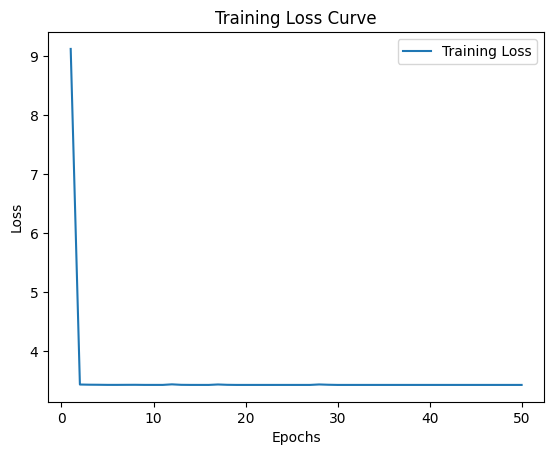

In [ ]:
import matplotlib.pyplot as plt

loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [ ]:
encoder_with_projection_head.save(save_path + 'lossxent_densenet.h5')

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/lossxent_densenet.h5', 
                               monitor='sparse_categorical_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
classifier.save(save_path + 'lossxent_resnet.h5')

In [ ]:
xent_densenet=load_model(save_path + 'lossxent_resnet.h5')

#Triplet Loss

In [ ]:
def triplet_loss(y_true, y_pred, alpha=0.2):     
    anchors = y_pred[0]
    positives = y_pred[1]
    negatives = y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchors, positives)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchors, negatives)), axis=-1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

In [ ]:
def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="densenet-encoder_with_projection-head"
    )
    return model

In [ ]:
densenet_tripletloss_dict={}

In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=triplet_loss,
)
encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train_onehot, batch_size=batch_size, epochs=50
)


Model: "densenet-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 DenseNet169-encoder (Functi  (None, 1664)             12642887  
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 128)               213120    
                                                                 
Total params: 12,856,007
Trainable params: 12,697,600
Non-trainable params: 158,407
_________________________________________________________________
Epoch 1/50
567/567 [==============================] - 184s 150ms/step - loss: 1.7440
Epoch 2/50
567/567 [==============================] - 83s 146ms/step - loss: 0.2530
Epoch 3/50
567/567 [====================

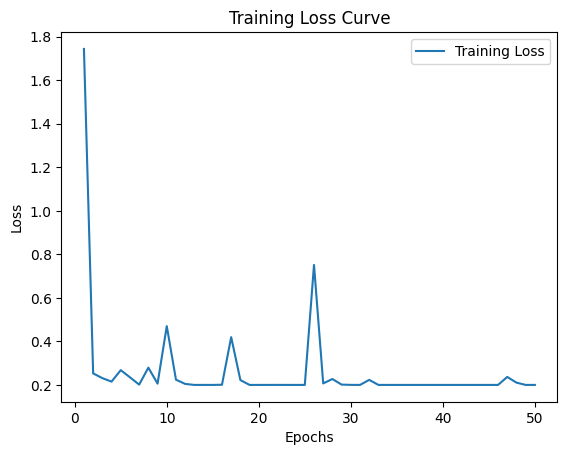

In [ ]:
import matplotlib.pyplot as plt

loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()